# Quantum Computing Using Amazon Braket
#### Chapter 5 - Using Quantum Annealer - Developing a QUBO function and using Constraints

#### 3 variable example
© 2021, 2022 Packt Publishing

#### Written by Alex Khan

#### 1. First QUBO example using ExactSolver()

In [1]:
import dimod

Our goal is to minimize the following cost function

$ minimize\ (\ a_0x_0\ {+\ a}_1x_1+a_2x_2+a_{01}x_0x_1+a_{02}x_0x_2+\ a_{12}x_1x_2\ )\ \ eq.\ (2)\ $ 

The values of the coefficients are given in the equation below

$minimize\ (\ -0.5x_0\ +\ x_1\ -\ 0.75x_2+0.5x_0x_1\ -\ 0.25x_0x_2+\ 0.25x_1x_2\ )\ \ eq.\ (3)$

This is also represented in the graph form

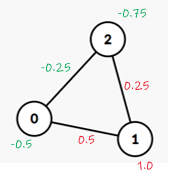

Let us define the coefficients in a dictionary form

First we will create the **linear coefficients**. The linear coefficients $a_0, a_1, a_2$ are associated with the variables $x_0, x_1$ and $x_2.$

In [2]:
linear={('x0'):-0.5, ('x1'):1.0, ('x2'):-0.75}
print(linear)

{'x0': -0.5, 'x1': 1.0, 'x2': -0.75}


Next we insert the **quadratic coefficients**. The quadratic coefficients $a_{01}, a_{02}, a_{12}$ are the coupling terms between the pair of variables $x_0x_1, x_0x_2,$ and $x_1x_2$

In [3]:
quadratic={('x0','x1'):0.5, ('x0','x2'):-0.25, ('x1','x2'):0.25}
print(quadratic)

{('x0', 'x1'): 0.5, ('x0', 'x2'): -0.25, ('x1', 'x2'): 0.25}


now we can use the **dimod** function **BinaryQuadraticModel** to combine these two linear and quadratic terms and also identify the variables $(x_0...x_2)$ as **Binary**.

In [4]:
vartype = dimod.BINARY
bqm = dimod.BinaryQuadraticModel(linear, quadratic, vartype)

We are now ready to execute this cost function on the dimod local solver that will accurately produce all the appropriate cost values for the different combination of x values as 0 or 1. The solution is then sorted with the lowest cost shown first.

In [5]:
sampler = dimod.ExactSolver()
response = sampler.sample(bqm)
print(response)


  x0 x1 x2 energy num_oc.
6  1  0  1   -1.5       1
7  0  0  1  -0.75       1
1  1  0  0   -0.5       1
0  0  0  0    0.0       1
5  1  1  1   0.25       1
4  0  1  1    0.5       1
2  1  1  0    1.0       1
3  0  1  0    1.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


The first row shows that the lowest cost solution has a value of -1.5 and requires $x_0=1, x_1=0$ and $x_2=1.$ The next lowest energy of -0.75 is found when only $x_2=1,$ while $x_0$ and $x_1$ are 0.

#### 2. Running the 3 variable problem on D-Wave annealer

Please enter the appropriate bucket name and your folder name below.

In [6]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

We will import additional libraries needed from Braket to designate the D-Wave sampler perform the embedding and then run the solver through Amazon Braket.

In [7]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

In [8]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [9]:
available_devices()

['Advantage_system4.1',
 'Advantage_system6.1',
 'Aspen-M-1',
 'DW_2000Q_6',
 'IonQ Device',
 'SV1',
 'TN1',
 'dm1']

We will designate the 'DW_2000Q_6' as the device and then use the BraketDWaveSampler function to set up the sampler and the EmbeddingComposite function to map the variables to the lattice of qubits on D-Wave 2000Q. We also find some properties of the device and print them out.

In [18]:
DWave_device='DW_2000Q_6' #if using 2000Q
# DWave_device='Advantage_system6.1' #if using advantage 6.1
# DWave_device='Advantage_system4.1' #if using advantage 4.1

# Please run available_devices() to validate the latest QPU available and edit the above list

device =AwsDevice.get_devices(names=DWave_device)[0]
sampler = BraketDWaveSampler(s3_folder,device.arn)
sampler = EmbeddingComposite(sampler)
max_shots=device.properties.service.shotsRange[1]
print('Number of qubits: ', device.properties.provider.qubitCount)
print('Number of couplers', len(device.properties.provider.couplers))
print('Shots max {:,}'.format(max_shots) )

Number of qubits:  2048
Number of couplers 5974
Shots max 10,000


The code below allows us to estimate the number of shots that are desired for the three variables and and the price.

In [19]:
#Estimate cost:
variables=3
shots=25*2**variables
if shots>max_shots:
    shots=max_shots
price_per_shot=device.properties.service.deviceCost.price
print('Recommended shots', shots)
print('Estimated cost ${:.2f}'.format(0.3+price_per_shot*shots))

Recommended shots 200
Estimated cost $0.34


Chain strength is not needed with such a small number of variables, the embedding will use one qubit per variable, so there will be no "chain" of qubits that represent one variable. Finally we run the D-Wave sampler using the binary quadratic model of our problem cost function, and the required shots.

In [20]:
#chainstrength = 1
response = sampler.sample(bqm, num_reads=shots)


In [21]:
print(response)

  x0 x1 x2 energy num_oc. chain_.
0  1  0  1   -1.5     200     0.0
['BINARY', 1 rows, 200 samples, 3 variables]


The solution shows that D-Wave find x_0=1, x_1=0 and x_2=1 as the best solution with the lowest cost value of -1.5. Notice that D-Wave found this for all 200 shots. This clearly shows that D-Wave was efficiently able to find this solution.